In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import random
import time
import warnings
import gc
import tracemalloc
import sys
import pptk

import json
import copy

from utils import *
#from lib.AcceleratorMethods.AcceleratorMethods import *

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 160

cmap = cm.get_cmap('viridis', 101)
viridis = np.ndarray((101, 4))
for i in range(0, 101):
    viridis[i] = cmap(i/100)
    
cmap = cm.get_cmap('magma', 101)
magma = np.ndarray((101, 4))
for i in range(0, 101):
    magma[i] = cmap(i/100)
    
cmap = cm.get_cmap('inferno', 101)
inferno = np.ndarray((101, 4))
for i in range(0, 101):
    inferno[i] = cmap(i/100)
    
cmap = cm.get_cmap('prism', 101)
prism = np.ndarray((101, 4))
for i in range(0, 101):
    prism[i] = cmap(i/100)
    
cmap = cm.get_cmap('flag', 101)
flag = np.ndarray((101, 4))
for i in range(0, 101):
    flag[i] = cmap(i/100)
    
cmap = cm.get_cmap('ocean', 101)
ocean = np.ndarray((101, 4))
for i in range(0, 101):
    ocean[i] = cmap(i/100)
    
cmap = cm.get_cmap('tab10', 10)
tab10 = np.ndarray((10, 4))
for i in range(0, 10):
    tab10[i] = cmap(i/10)
    
cmap = cm.get_cmap('Set1', 9)
set1 = np.ndarray((9, 4))
for i in range(0, 9):
    set1[i] = cmap(i/9)

In [2]:
import Cython
%load_ext Cython

In [33]:
%%cython
cimport cython
import numpy as np
cimport numpy as np




@cython.boundscheck(False)
@cython.wraparound(False)
def calculateLocalEnergy(center, np.int8_t[:,:,:,:] grid, np.double_t[:,:,:,:] e_grid, int species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t z = center[2]
    cdef Py_ssize_t x_max = grid.shape[2]
    cdef Py_ssize_t y_max = grid.shape[1]
    cdef Py_ssize_t z_max = grid.shape[0]
    cdef np.int8_t[:,:,:,:] grid_view = grid
    cdef np.double_t[:,:,:,:] e_view = e_grid
    cdef float[:,:] weights_view = weights
    
    if extra_memory == True:
        return e_view[z,y,x, species-1]
    
    energy = 0
    cdef Py_ssize_t i, ii, j, jj, k, kk
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = (y + j) % y_max
            for k in [-1, 0, 1]:
                kk = z + k
                # only compute with neighbors within bounds
                if (i == 0 and j == 0 and k == 0) or kk < 0 or kk > z_max-1:
                    continue
                if (i == 0 and j == 0) or (i == 0 and k == 0) or (j == 0 and k == 0):
                    # shares side
                    energy += weights_view[int(species), grid_view[kk,jj,ii,0]]
                elif i == 0 or j == 0 or k == 0:
                    # shares edge
                    energy += weights_view[int(species), grid_view[kk,jj,ii,0]]/1.414
                elif i != 0 and j != 0 and k != 0:
                    # shares corner
                    energy += weights_view[int(species), grid_view[kk,jj,ii,0]]/1.732
    return energy

@cython.boundscheck(False)
@cython.wraparound(False)
def updateLocalEnergy(center, np.int8_t[:,:,:,:] grid, np.double_t[:,:,:,:] e_grid, int species, int max_species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t z = center[2]
    cdef Py_ssize_t x_max = grid.shape[2]
    cdef Py_ssize_t y_max = grid.shape[1]
    cdef Py_ssize_t z_max = grid.shape[0]
    cdef np.int8_t[:,:,:,:] grid_view = grid
    cdef np.double_t[:,:,:,:] e_view = e_grid
    cdef float[:,:] weights_view = weights
    
    cdef Py_ssize_t i, ii, j, jj, k, kk
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = (y + j) % y_max
            for k in [-1, 0, 1]:
                kk = z + k
                # only compute with neighbors within bounds
                if (i == 0 and j == 0 and k == 0) or kk < 0 or kk > z_max-1:
                    continue
                for s in range(1, max_species+1):
                    e_view[kk,jj,ii,species-1] += weights_view[grid_view[kk,jj,ii,0], int(s)]
    return


@cython.boundscheck(False)
@cython.wraparound(False)
def getAdjacentVacancies(center, np.int8_t[:,:,:,:] grid, np.double_t[:,:,:,:] e_grid, int species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t z = center[2]
    cdef Py_ssize_t x_max = grid.shape[2]
    cdef Py_ssize_t y_max = grid.shape[1]
    cdef Py_ssize_t z_max = grid.shape[0]
    cdef np.int8_t[:,:,:,:] grid_view = grid
    
    #assert center.dtype == np.uint8
    #assert grid.dtype == np.int8
    
    vacancy_list = []
    weight_list = []
    cdef Py_ssize_t i, ii, j, jj, k, kk
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = (y + j) % y_max
            for k in [-1, 0, 1]:
                kk = z + k
                if kk < 0 or kk > z_max-1:
                    continue
                if grid_view[kk,jj,ii,0] == 0 and (grid_view[kk,jj,ii,1] > 0 or kk == 0):
                    if len(weights) > 0:
                        weight_list.append(calculateLocalEnergy((ii,jj,kk), grid, e_grid, species, weights, extra_memory))
                    vacancy_list.append((ii,jj,kk))
    return vacancy_list, weight_list

@cython.boundscheck(False)
@cython.wraparound(False)
def getAdjacentParticles(center, np.int8_t[:,:,:,:] grid, np.double_t[:,:,:,:] e_grid, int species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t z = center[2]
    cdef Py_ssize_t x_max = grid.shape[2]
    cdef Py_ssize_t y_max = grid.shape[1]
    cdef Py_ssize_t z_max = grid.shape[0]
    cdef np.int8_t[:,:,:,:] grid_view = grid
    
    #assert center.dtype == np.uint8
    #assert grid.dtype == np.int8
    
    vacancy_list = []
    weight_list = []
    cdef Py_ssize_t i, ii, j, jj, k, kk
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = (y + j) % y_max
            for k in [-1, 0, 1]:
                kk = z + k
                if kk < 0 or kk > z_max-1:
                    continue
                if grid_view[kk,jj,ii,0] == 1 and (grid_view[kk,jj,ii,1] > 0 or kk == 0):
                    if len(weights) > 0:
                        weight_list.append(calculateLocalEnergy((ii,jj,kk), grid, e_grid, species, weights, extra_memory))
                    vacancy_list.append((ii,jj,kk))
    return vacancy_list, weight_list

@cython.boundscheck(False)
@cython.wraparound(False)
def traverseCalculatedPath(float[:,:] path, np.int8_t[:,:,:] grid, float[:] dest, log, str log_content):
    cdef np.int8_t[:,:,:] grid_view = grid
    cdef float[:,:] points = path
    cdef float[:] off = dest
    cdef Py_ssize_t height = grid.shape[0]
    cdef Py_ssize_t L = grid.shape[1]
    cdef int i
    
    for i in range(0, len(path)):
        if grid_view[int(points[i,2]), int(round((points[i,1]+off[1]) % L)), int(round((points[i,0]+off[0]) % L))] > 0:
            # intersection before reaching end destination
            if points[i-1,2] < height:
                collision = (int(points[i,2]), int(round((points[i,1]+off[1]) % L)), int(round((points[i,0]+off[0]) % L)))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
        elif int(round((points[i,0]+off[0]) % L)) == int(round(off[0])) and int(round((points[i,1]+off[1]) % L)) == int(round(off[1])) and int(round(points[i,2])) == int(round(off[2])):
            if off[2] < height:
                collision = (int(off[2]), int(round(off[1])), int(round(off[0])))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
    return collision

@cython.boundscheck(False)
@cython.wraparound(False)
def traversePathRealTime(float[:] source, float[:] destination, np.int8_t[:,:,:] grid):
    cdef np.int8_t[:,:,:] grid_view = grid
    cdef float[:] src = source
    cdef float[:] dest = destination
    cdef Py_ssize_t height = grid.shape[0]
    cdef Py_ssize_t L = grid.shape[1]
    
    dx = abs(dest[0] - src[0])
    dy = abs(dest[1] - src[1])
    dz = abs(dest[2] - src[2])
    if (dest[0] > src[0]):
        xs = 1
    else:
        xs = -1
    if (dest[1] > src[1]):
        ys = 1
    else:
        ys = -1
    if (dest[2] > src[2]):
        zs = 1
    else:
        zs = -1
    x1 = src[0]
    y1 = src[1]
    z1 = src[2]
    x2 = dest[0]
    y2 = dest[1]
    z2 = dest[2]
    
    # Driving axis is X-axis"
    if (dx >= dy and dx >= dz):  
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while (x1 != x2):
            if grid_view[int(z1), int(round(y1 % L)), int(round(x1 % L))] > 0:
                return (int(z1), int((y1)% L), int((x1) % L))
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
        return (int(z1), int((y1)% L), int((x1) % L))
    # Driving axis is Y-axis"
    elif (dy >= dx and dy >= dz):
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while (y1 != y2):
            if grid_view[int(z1), int(round(y1 % L)), int(round(x1 % L))] > 0:
                return (int(z1), int((y1)% L), int((x1) % L))
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
        return (int(z1), int((y1)% L), int((x1) % L))
    # Driving axis is Z-axis"
    else:        
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while (z1 != z2):
            if grid_view[int(z1), int(round(y1 % L)), int(round(x1 % L))] > 0:
                return (int(z1), int((y1)% L), int((x1) % L))
            z1 += zs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dz
            if (p2 >= 0):
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
        return (int(z1), int((y1)% L), int((x1) % L))

# Point3D, Vertex, and Surface3D classes

In [4]:
class Point3D:
    def __init__(self, x, y, z, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x = int(round(x))
        self.y = int(round(y))
        self.z = int(round(z))
        
    def __repr__(self):
        return "Point({}, {}, {})".format(self.x, self.y, self.z)
    
    def __str__(self):
        return "({}, {}, {})".format(self.x, self.y, self.z)
    
class Vertex:
    def __init__(self):
        super().__init__()
        self.depth = np.Inf  # depth in tree, np.Inf if disconnected
        self.parent = np.Inf # unrolled index in grid (x + y*W + z*W*L); np.Inf if disconnected, -1 for substrate
        self.children = []   # list of unrolled indices in grid
        
    def __str__(self):
        return "Parent: {}\nChildren: {}\nDepth: {}".format(self.parent, self.children, self.depth)


In [34]:
class ParticleGraph:
    def __init__(self, length, height, width=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._L = length
        self._h = height
        if width is None:
            self._w = length
        else:
            self._w = width
        self.vertices = []
        for i in range(0, self._L * self._w * self._h):
            self.vertices.append(Vertex())
        #self.vertices = [vertex() for _ in range(self._L * self._w * self._h)] # make a bunch of vertices
    
    def unwrap(self, p):
        return p[0] + p[1]*self._w + p[2]*self._w*self._L
    
    def wrap(self, num):
        k = int(np.floor(num / self._w / self._L))
        j = int(np.floor((num - k * self._w * self._L) / self._L))
        i = int(num - j * self._L - k * self._w * self._L)
        return (i,j,k)
    
    def _printVertex(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        return "Index: {}\n{}".format(index, self.vertices[index])
    
    def _getVertex(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        return self.vertices[index]
    
    def getDepth(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        return self.vertices[index].depth
    
    def getDepthByIndex(self, p):
        return self.vertices[p].depth
    
    def getParent(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        return self.vertices[index].parent
    
    def getChildren(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        return self.vertices[index].children
    
    def setDepth(self, p, depth):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        self.vertices[index].depth = depth
    
    def setParent(self, p, parent):
        if isinstance(p, tuple):
            indexp = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            indexp = p
        if isinstance(parent, tuple):
            index = parent[0] + parent[1]*self._w + parent[2]*self._w*self._L
        else:
            index = parent
        self.vertices[indexp].parent = index
    
    def setParentByIndex(self, p, parent):
        self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].parent = parent
    
    def addChild(self, p, child):
        if isinstance(child, tuple):
            index = child[0] + child[1]*self._w + child[2]*self._w*self._L
        else:
            index = child
        if index not in self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].children:
            self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].children.append(index)
        
    def addVertex(self, p):
        if z == self._h - 1:
            self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].parent = -1
            self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].depth = 0
            
    def removeVertex(self, p):
        self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].children.clear()
        self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].parent = np.Inf
        self.vertices[p[0] + p[1]*self._w + p[2]*self._w*self._L].depth = np.Inf
        
    def removeChild(self, p, child):
        if isinstance(p, tuple):
            indexp = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            indexp = p
        if isinstance(child, tuple):
            indexc = child[0] + child[1]*self._w + child[2]*self._w*self._L
        else:
            indexc = child
        if indexc in self.vertices[indexp].children:
            self.vertices[indexp].children.remove(indexc)
        
    def clearChildren(self, p):
        if isinstance(p, tuple):
            index = p[0] + p[1]*self._w + p[2]*self._w*self._L
        else:
            index = p
        self.vertices[index].children.clear()
    
''' Holds all surface points for quick access '''
class Surface3D:
    def __init__(self, length, height, width=None, species=[], weights=[], cython=False, extra_memory=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._L = length
        self._h = height
        if width is None:
            self._w = length
        else:
            self._w = width
        if len(species) > 0:
            self.species = species
        else:
            self.species = [1]
        self._max_species = max(species)
        if len(weights) > 0:
            self.weights = weights
        else:
            self.weights = np.array([[1,0], [0,1]])
        self.cython=cython
        self.extra_memory=extra_memory
        #self.pointlist = list()
        if self.extra_memory and self.cython:
            self.pointgrid = np.zeros((self._h, self._L, self._w, 2)).astype(np.int8) # (z, y, x, speciesnearest neighbors/energy[])
            self.energygrid = np.zeros((self._h, self._L, self._w, self._max_species), dtype=np.float64)
        else:
            self.pointgrid = np.zeros((self._h, self._L, self._w, 2)).astype(np.int8) # (z, y, x, species/nearest neighbors)
            self.energygrid = np.zeros([1,1,1,1], dtype=np.float64)
        #self.pointgrid[:,:,:,0] = -1
        #self.pointgrid[:,:,:,1] = 0
        #self.pointgrid[:,:,:,2] = 0
        #self.BFS = ParticleGraph(self._L, self._h, self._w)
        
    def add(self, point, species=1):
        if species == 0:
            raise ValueError("Species must be an integer greater than 0 (value passed: {}).".format(species))
        
        # add point
        #self.pointlist.append((point[0], point[1], point[2]))
        #self.pointgrid[point[2], point[1], point[0], 0] = len(self.pointlist)-1
        self.pointgrid[point[2], point[1], point[0], 0] = species
        
        # update nearest neighbors grid
        self.pointgrid[point[2], (point[1]-1) % self._L, point[0], 1] += 1
        self.pointgrid[point[2], (point[1]+1) % self._L, point[0], 1] += 1
        self.pointgrid[point[2], (point[1]-1) % self._L, (point[0]-1) % self._w, 1] += 1
        self.pointgrid[point[2], (point[1]+1) % self._L, (point[0]+1) % self._w, 1] += 1
        self.pointgrid[point[2], (point[1]-1) % self._L, (point[0]+1) % self._w, 1] += 1
        self.pointgrid[point[2], (point[1]+1) % self._L, (point[0]-1) % self._w, 1] += 1
        self.pointgrid[point[2], point[1] % self._L, (point[0]-1) % self._w, 1] += 1
        self.pointgrid[point[2], point[1] % self._L, (point[0]+1) % self._w, 1] += 1
        if point[2] < self._h - 1:
            self.pointgrid[point[2]+1, point[1], point[0], 1] += 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, point[0], 1] += 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, point[0], 1] += 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, (point[0]+1) % self._w, 1] += 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, (point[0]+1) % self._w, 1] += 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]+1, point[1] % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]+1, point[1] % self._L, (point[0]+1) % self._w, 1] += 1
        if point[2] > 0:
            self.pointgrid[point[2]-1, point[1], point[0], 1] += 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, point[0], 1] += 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, point[0], 1] += 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, (point[0]+1) % self._w, 1] += 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, (point[0]+1) % self._w, 1] += 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]-1, point[1] % self._L, (point[0]-1) % self._w, 1] += 1
            self.pointgrid[point[2]-1, point[1] % self._L, (point[0]+1) % self._w, 1] += 1
        
        if self.extra_memory and self.cython:
            updateLocalEnergy(point, self.pointgrid, self.energygrid, species, self._max_species, self.weights, self.extra_memory)
            
        # BFS tree update
        #if point[2] == self._h - 1:
        #    # root is substrate
        #    self.BFS.setParent(point, -1)
        #    depth = 0
        #    self.BFS.setDepth(point, depth)
        #else:
        #    # find lowest depth neighbor and set as parent with incremented depth
        #    min_depth = np.Inf
        #    parent = None
        #    nn = self.getNearestNeighbors(point)
        #    if len(nn) == 0:
        #        raise ValueError("Particle added at {} has no neighbors.".format(point))
        #    for n in nn:
        #        d = self.BFS.getDepth(n)
        #        if d < min_depth:
        #            parent = n
        #    if parent == None:
        #        print("No nearest neighbors {} of {} have depth.".format(nn, point))
        #    depth = self.BFS.getDepth(parent) + 1
        #    self.BFS.setParent(point, parent)
        #    self.BFS.setDepth(point, depth)
        #    self.BFS.addChild(parent, point)
        #self.updateGraphAddition(point)
                
        
    def remove(self, point):
        # get index, remove from list, and set grid point to no index
        #index = self.pointgrid[point[2], point[1], point[0], 0]
        #self.pointlist.pop(index)
        #self.pointgrid[point[2], point[1], point[0], 0] = -1
        self.pointgrid[point[2], point[1], point[0], 0] = 0
        
        # update grid indices
        #for i in range(index, len(self.pointlist)):
        #    self.pointgrid[self.pointlist[i][2], self.pointlist[i][1], self.pointlist[i][0], 0] = i
            
        # update nearest neighbors grid
        self.pointgrid[point[2], (point[1]-1) % self._L, point[0], 1] -= 1
        self.pointgrid[point[2], (point[1]+1) % self._L, point[0], 1] -= 1
        self.pointgrid[point[2], (point[1]-1) % self._L, (point[0]-1) % self._w, 1] -= 1
        self.pointgrid[point[2], (point[1]+1) % self._L, (point[0]+1) % self._w, 1] -= 1
        self.pointgrid[point[2], (point[1]-1) % self._L, (point[0]+1) % self._w, 1] -= 1
        self.pointgrid[point[2], (point[1]+1) % self._L, (point[0]-1) % self._w, 1] -= 1
        self.pointgrid[point[2], point[1] % self._L, (point[0]-1) % self._w, 1] -= 1
        self.pointgrid[point[2], point[1] % self._L, (point[0]+1) % self._w, 1] -= 1
        if point[2] < self._h - 1:
            self.pointgrid[point[2]+1, point[1], point[0], 1] -= 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, point[0], 1] -= 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, point[0], 1] -= 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, (point[0]+1) % self._w, 1] -= 1
            self.pointgrid[point[2]+1, (point[1]-1) % self._L, (point[0]+1) % self._w, 1] -= 1
            self.pointgrid[point[2]+1, (point[1]+1) % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]+1, point[1] % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]+1, point[1] % self._L, (point[0]+1) % self._w, 1] -= 1
        if point[2] > 0:
            self.pointgrid[point[2]-1, point[1], point[0], 1] -= 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, point[0], 1] -= 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, point[0], 1] -= 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, (point[0]+1) % self._w, 1] -= 1
            self.pointgrid[point[2]-1, (point[1]-1) % self._L, (point[0]+1) % self._w, 1] -= 1
            self.pointgrid[point[2]-1, (point[1]+1) % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]-1, point[1] % self._L, (point[0]-1) % self._w, 1] -= 1
            self.pointgrid[point[2]-1, point[1] % self._L, (point[0]+1) % self._w, 1] -= 1
        
        if self.extra_memory:
            for i in range(1, self._max_species+1):
                updateLocalEnergy(point, self.pointgrid, self.energygrid, i, self.weights, self.extra_memory)
        
        # BFS tree update
        #parent = self.BFS.getParent(point)
        #if parent > -1:
        #    c = self.BFS._getVertex(self.BFS.wrap(parent)).children
        #    self.BFS.removeChild(parent, self.BFS.unwrap(point))
        #self.BFS.removeVertex(point)
    
    
    def updateGraphAddition(self, vertex):
        depth = self.BFS.getDepth(vertex)
        nn = self.getNearestNeighbors(vertex)
        #print(vertex, depth, nn)
        for n in nn:
            if self.BFS.getDepth(n) > depth + 1:
                self.BFS.setDepth(n, depth + 1)
                
                # remove old parent
                op = self.BFS.getParent(n)
                self.BFS.removeChild(op, self.BFS.unwrap(n))
                #print('\t', n, op)
                
                # pair vertex and new child
                self.BFS.setParent(n, vertex)
                self.BFS.addChild(vertex, n)
                
                # recursion on the new child
                self.updateGraphAddition(n)
                
        
    def updateGraphFrom(self, root):
        depth = self.BFS.getDepth(root)
        children = self.BFS.getChildren(root)
        for c in children:
            x = self.BFS.wrap(c)
            self.setDepth(x, depth + 1)
            self.updateGraphDeletion(x)
        
        
    def isArticulationPoint(self, vertex):
        # get index, depth, and children of vertex
        v = vertex[0] + vertex[1]*self._w + vertex[2]*self._w*self._L
        depth = self.BFS.getDepth(vertex)
        children = self.BFS.getChildren(vertex).copy()
        
        if len(children) == 0:
            return False, []
        
        # check connectivity for each child
        parents = []
        no_change = True
        i = 0
        while len(children) > 0:
            # get child
            child = self.BFS.wrap(children[i])
            neighbors = self.getNearestNeighbors(child)
            # if there's only one neighbor it has to be the former parent
            if len(neighbors) == 1:
                return True, []
            # iterate up the neighbors to check connectivity to something higher
            p_depth = np.Inf
            connected = False
            #print(neighbors)
            for neighbor in neighbors:
                if connected:
                    break
                if neighbor in children or neighbor == vertex:
                    continue
                # get parent and parent depth
                parent = self.BFS.getParent(neighbor)
                p_depth = self.BFS.getDepthByIndex(parent)
                
                # recursively go up parent list to find a new parent
                while parent != v:
                    #print(parent)
                    parent = parent
                    #parent = self.BFS.getParent(neighbor)
                    
                    # if the parent is on the substrate it's a good root
                    if parent == -1:
                        connected = True
                        parents.append(neighbor)
                        no_change = False
                        children.pop(i)
                        break
                    p_depth = self.BFS.getDepthByIndex(parent)
                    
                    # if the parent has a depth at most the original vertex it is a good parent
                    if p_depth <= depth:
                        connected = True
                        parents.append(self.BFS.wrap(parent))
                        no_change = False
                        children.pop(i)
                        break
                    parent = self.BFS.getParent(parent)
            if i == len(children) - 1 and no_change:
                return True, []
            else:
                no_change = True
            if len(children) > 0:
                if not connected:
                    i = (i + 1) % len(children)
                else:
                    i = i % len(children)
        return False, parents
    
    def disconnectSubgraph(self, root):
        self.BFS.setDepth(root, np.Inf)
        children = self.BFS.getChildren(root)
        for c in children:
            self.disconnectSubgraph(c)
        self.BFS.clearChildren(root)
    
    def removePoint(self, point):
        #print(point)
        art_point, roots = self.isArticulationPoint(point)
        if art_point:
            return False
        
        children = self.BFS.getChildren(point)
        
        for c in children:
            self.disconnectSubgraph(point)
        
        self.remove(point)
        
        for r in roots:
            self.updateGraphAddition(r)
        
        return True
            
    def is_surface(self, point):
        if self.pointgrid[point[2], point[1], point[0], 0] > 0:
            return True
        else:
            return False
        
    def random_point(self):
        return self.pointlist[random.randint(0, len(self.pointlist) - 1)]
    
    def getNearestNeighbors(self, center):
        neighbor_list = []
        for i in [-1, 0, 1]:
            ii = (center[0] + i) % self._w
            for j in [-1, 0, 1]:
                jj = (center[1] + j) % self._L
                for k in [-1, 0, 1]:
                    kk = center[2] + k
                    if kk < 0:
                        continue
                    if kk > self._h-1:
                        continue
                    if self.pointgrid[kk,jj,ii,0] > 0 and not (i == 0 and j == 0 and k == 0):
                        neighbor_list.append((ii,jj,kk))
        return neighbor_list
    
    def getDiffusableNeighbors(self, center, box_size=(3,3,3)):
        neighbor_list = []
        for i in range(-box_size[2]//2,box_size[2]//2+1):
            ii = (center[0] + i) % self._w
            for j in range(-box_size[1]//2,box_size[1]//2+1):
                jj = (center[1] + j) % self._L
                for k in range(-box_size[0]//2,box_size[0]//2+1):
                    kk = center[2] + k
                    if kk < 0:
                        continue
                    if kk > self._h-1:
                        continue
                    if self.pointgrid[kk,jj,ii,0] > 0 and self.pointgrid[kk,jj,ii,1] < 26:
                        if not self.isLocalArticulationPoint([ii,jj,kk]):
                            neighbor_list.append((ii,jj,kk))
        return neighbor_list
    
    def getAdjacentVacancy(self, center, species=1, weights=[], deterministic=False):
        if self.cython:
            vacancy_list, weight_list = getAdjacentVacancies(center, self.pointgrid, self.energygrid, species, weights, self.extra_memory)
            if len(vacancy_list) == 0:
                return None
            try:
                if len(weights) > 0:
                    if deterministic:
                        return(vacancy_list[np.argmax(weight_list)])
                    mi = np.amin(weight_list)
                    ma = np.amax(weight_list)
                    if ma < 0:
                        for w in weight_list:
                            w -= mi
                    else:
                        if mi < 0:
                            for w in weight_list:
                                if w < 0:
                                    w = 0
                    return random.choices(vacancy_list, weights=weight_list)[0]
                return vacancy_list[random.randint(0, len(vacancy_list)-1)]
            except ValueError:
                print("Surface atoms:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,0]))
                print("Nearest neighbors:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,1]))
                return None
            
        vacancy_list = []
        weight_list = []
        for i in [-1, 0, 1]:
            try:
                ii = (center[0] + i) % self._w
            except TypeError:
                print(i,center)
                raise TypeError()
            for j in [-1, 0, 1]:
                jj = (center[1] + j) % self._L
                for k in [-1, 0, 1]:
                    kk = center[2] + k
                    #print(ii,jj,kk)
                    if kk < 0:
                        continue
                    if kk > self._h-1:
                        continue
                    if self.pointgrid[kk,jj,ii,0] == 0 and (self.pointgrid[kk,jj,ii,1] > 0 or kk == self._h-1):
                        if len(weights) > 0:
                            weight_list.append(self.calculateLocalEnergy((ii,jj,kk), species, weights=weights))
                        vacancy_list.append((ii,jj,kk))
        if len(vacancy_list) == 0:
            return None
        try:
            if len(weights) > 0:
                return random.choices(vacancy_list, weights=weight_list)[0]
            return vacancy_list[random.randint(0, len(vacancy_list)-1)]
        except ValueError:
            print("Surface atoms:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,0]))
            print("Nearest neighbors:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,1]))
            return None
        
    def getAdjacentParticle(self, center, species=1, weights=[], deterministic=False):
        if self.cython:
            vacancy_list, weight_list = getAdjacentParticles(center, self.pointgrid, self.energygrid, species, weights, self.extra_memory)
            if len(vacancy_list) == 0:
                return None
            try:
                if len(weights) > 0:
                    if deterministic:
                        return(vacancy_list[np.argmin(weight_list)])
                    mi = np.amin(weight_list)
                    ma = np.amax(weight_list)
                    if ma < 0:
                        for w in weight_list:
                            w -= mi
                    else:
                        if mi < 0:
                            for w in weight_list:
                                if w < 0:
                                    w = 0
                    return random.choices(vacancy_list, weights=weight_list[::-1])[0]
                return vacancy_list[random.randint(0, len(vacancy_list)-1)]
            except ValueError:
                print("Surface atoms:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,0]))
                print("Nearest neighbors:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,1]))
                return None
            
        vacancy_list = []
        weight_list = []
        for i in [-1, 0, 1]:
            try:
                ii = (center[0] + i) % self._w
            except TypeError:
                print(i,center)
                raise TypeError()
            for j in [-1, 0, 1]:
                jj = (center[1] + j) % self._L
                for k in [-1, 0, 1]:
                    kk = center[2] + k
                    #print(ii,jj,kk)
                    if kk < 0:
                        continue
                    if kk > self._h-1:
                        continue
                    if self.pointgrid[kk,jj,ii,0] == 0 and (self.pointgrid[kk,jj,ii,1] > 0 or kk == self._h-1):
                        if len(weights) > 0:
                            weight_list.append(self.calculateLocalEnergy((ii,jj,kk), species, weights=weights))
                        vacancy_list.append((ii,jj,kk))
        if len(vacancy_list) == 0:
            return None
        try:
            if len(weights) > 0:
                return random.choices(vacancy_list, weights=weight_list)[0]
            return vacancy_list[random.randint(0, len(vacancy_list)-1)]
        except ValueError:
            print("Surface atoms:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,0]))
            print("Nearest neighbors:\n{}".format(self.pointgrid[center[2]-1:center[2]+2,center[1]-1:center[1]+2,center[0]-1:center[0]+2,1]))
            return None
            
            
    def calculateLocalEnergy(self, center, species, weights):
        if self.cython:
            return calculateLocalEnergy(center, self.pointgrid, self.energygrid, species, weights, self.extra_memory)
        energy = 0
        for i in [-1, 0, 1]:
            ii = (center[0] + i) % self._w
            for j in [-1, 0, 1]:
                jj = (center[1] + j) % self._L
                for k in [-1, 0, 1]:
                    kk = center[2] + k
                    if i == 0 and j == 0 and k == 0:
                        continue
                    #print(ii,jj,kk)
                    if kk < 0:
                        continue
                    if kk > self._h-1:
                        continue
                    try:
                        if (i == 0 and j == 0) or (i == 0 and k == 0) or (j == 0 and k == 0):
                            # shares side
                            energy += weights[int(species), self.pointgrid[kk,jj,ii,0]]
                        elif i == 0 or j == 0 or k == 0:
                            # shares edge
                            energy += weights[int(species), self.pointgrid[kk,jj,ii,0]]/1.414
                        elif i != 0 and j != 0 and k != 0:
                            # shares corner
                            energy += weights[int(species), self.pointgrid[kk,jj,ii,0]]/1.732
                        else:
                            print("Center {} and \"adjacent\" vertex {} are not adjacent.".format(center, (ii,jj,kk)))
                    except IndexError:
                        print("There is no weight for pair {}.".format((int(species), self.pointgrid[kk,jj,ii,0])))
        return energy
    
    def isLocalArticulationPoint(self, center):
        # particles with no neighbors cannot be articulation points
        if self.pointgrid[center[2], center[1], center[0], 1] == 0:
            return False
        
        # prepare region size
        size = 7
        s = size//2
        z1,z2 = ((center[2]-s), (center[2]+s+1))
        y1,y2 = ((center[1]-s) % self._L, (center[1]+s+1) % self._L)
        x1,x2 = ((center[0]-s) % self._w, (center[0]+s+1) % self._w)
        #region = self.pointgrid[z1:z2, y1:y2, x1:x2, 0]
        #print(z1,z2,y1,y2,x1,x2)
        #print((center[2]-s,center[2]+s+1), (center[1]-s,center[1]+s+1), (center[0]-s,center[0]+s+1))
        #print(region)
        #region[size//2,size//2,size//2] = 0
        
        # find lower neighbors that could be disconnected with a cut
        lower_neighbors = []
        for i in [-1, 0, 1]:
            ii = (center[0] + i) % self._w
            for j in [-1, 0, 1]:
                jj = (center[1] + j) % self._L
                for k in [-1, 0]:
                    #print(ii,jj,k+center[2])
                    if k+center[2] > 0 and k+center[2] < self._h:
                        if k != 0 or j != 0 or i != 0:
                            if self.pointgrid[k+center[2],jj,ii, 0] > -1:
                                lower_neighbors.append((ii, jj, k+center[2]))
        num = len(lower_neighbors)
        num_conf = 0
        #print(num)
        
        considered = []
        while len(lower_neighbors) > 0:
            queue = [lower_neighbors.pop(-1)]
            considered = []#queue[-1]]
            connected = False
            while len(queue) > 0:
                x = queue.pop(-1)
                considered.append(x)
                #print(x)
                if connected:
                    break
                for i in [-1, 0, 1]:
                    if connected:
                        break
                    ii = (x[0] + i) % self._w
                    for j in [-1, 0, 1]:
                        if connected:
                            break
                        jj = (x[1] + j) % self._L
                        for k in [1, 0, -1]: # Assume it's more efficient to choose top first
                            #print(ii,jj,k+x[2])
                            if i == 0 and j == 0 and k == 0:#k + x[2] == center[2] and j + x[1] == center[1] and i + x[0] == center[0]:
                                # skip the center
                                #print("center skipped")
                                continue
                            if k + x[2] < 0 or k+x[2] > self._h-1:
                                # top and bottom should be skipped
                                #print("edge skipped")
                                continue
                            if self.pointgrid[k+x[2], jj, ii, 0] > -1 and (ii, jj, k+x[2]) not in queue and (ii, jj, k+x[2]) not in considered and (ii, jj, k+x[2]) != center:
                                #print(k+x[2], size-1)
                                #print(queue, considered)
                                if k+x[2] == size - 1 or k+x[2] == self._h-1:
                                    # This particle is connected
                                    #print("Reached size-1")
                                    connected = True
                                    num_conf += 1
                                    break
                                elif (ii, jj, k+x[2]) in lower_neighbors:
                                    # We won't need to check this later, hurrah
                                    #print("In first queue")
                                    lower_neighbors.pop(lower_neighbors.index((ii, jj, k+x[2])))
                                    num_conf += 1
                                else:
                                    queue.append((ii, jj, k+x[2]))
                                #print(queue)
        #print(num, num_conf)
        if num_conf == num:
            return False
        else:
            return True
        
    def dumpInfo(self):
        x = ''
        for i in range(len(self.BFS.vertices)):
            point = self.BFS.wrap(i)
            if self.pointgrid[point[2], point[1], point[0], 0] > -1:
                v = self.BFS.vertices[i]
                x += "Index: {}\tPosition: {}\n".format(i, self.BFS.wrap(i))
                x += v.__str__()
                x += '\n'
        return x

In [5]:
# takes valued point list and generates a Surface3D object
def surfaceFromGrid(grid, L, H, species=[1], weights=np.array([[1,0],[0,1]]), cython=True, extra_memory=False):
    m = np.amax(grid, axis=0)
    surfaceAtoms = Surface3D(L, H, None, species, weights, cython, extra_memory)
    #l = np.array(np.where(grid!=0), dtype=np.int32).T, axis=1
    #for i in range(L):
    #    for j in range(L):
    #        for k in range(H-1, 0, -1):
    #            if grid[k,j,i] > 0:
    #                surfaceAtoms.add((i,j,k), species=grid[k,j,i])
    for i in range(grid.shape[0]):
        x = grid[i,:]
        surfaceAtoms.add([x[0], x[1], x[2]], species=x[3])
    return surfaceAtoms

In [37]:
def erode(theta=75, L=64, height=128, reps=8192, phi=0, turns=0, D=0, species=[1], inputSurface=None, inputGrid=None, weights=np.array([[1,0],[0,1]]), stepper_resolution=0, cython=True, extra_memory=False, deterministic=False, log=False):
    #tracemalloc.start()
    #snapshot = tracemalloc.take_snapshot()
    #top_stats = snapshot.statistics('lineno')
    start = time.time()
    maxh = height - 1
    hstep = 8
    grid = np.zeros((height, L, L)).astype(np.int8) # store particle state of each position
    weights = weights.astype(np.float32)
    if isinstance(inputGrid, np.ndarray):
        if grid.shape[1] < np.amax(inputGrid[:,0]) or grid.shape[2] < np.amax(inputGrid[:,1]) or grid.shape[0] < np.amax(inputGrid[:,2]):
            raise ValueError("Shape of grid {} and input grid {} do not match.".format(grid.shape, np.amax(inputGrid, axis=0)))
        else:
            for x in inputGrid:
                grid[x[2], x[1], x[0]] = x[3]
    if isinstance(species, int):
        species = [species]

    params = {'L': L, 
              'theta': theta, 
              'phi': phi, 
              'H': height, 
              'D': D, 
              'turns': turns, 
              'stepper resolution': stepper_resolution,
              'species': species, 
              'weights': weights, 
              'repetition': reps, 
              'time': 0}

    if log:
        log_content = "Deposition in {}x{}x{} box with {} repetitions\n".format(L, L, height, reps)
        log_content += "Deposition from {} deg and {} in-plane tilt\n".format(theta, phi)
        if turns > 0:
            log_content += "Helical with {} turns\n".format(turns)
        if D > 0:
            log_content += "{} diffusion steps chosen within {} of collision point\n".format(D, nn_dist)
        vertex_dump = ''
    else:
        log_content = None
        
    # rotation parameters
    dphi = turns*360/reps
    if dphi != 0.0:
        if stepper_resolution == 0:
            printd = "Rotating {:.4e} degrees between consecutive particles.".format(dphi)
        else:
            printd = "Rotating {:.4e} degrees between consecutive particles; clipped to increments of {:.3e}.".format(dphi, 360/stepper_resolution)
        print(printd)
        if log:
            log_content += printd

    # create surface
    surfaceAtoms = Surface3D(length=L, height=height, width=None, species=species, weights=weights, cython=cython, extra_memory=extra_memory)
    if isinstance(inputGrid, np.ndarray):
        surfaceAtoms = surfaceFromGrid(inputGrid, L, height, species, weights, cython, extra_memory)
        surfaceAtoms.cython = cython
    
    # create path to use with offsets
    src = [int(round(maxh/tand(theta-90)*cosd(phi))), int(round(maxh/tand(theta-90)*sind(phi))), maxh]
    dest = (0, 0, 0)
    points = Bresenham3D(src, dest)
    path = np.zeros((len(points), 3), dtype=np.float32)
    print("Calculated path length: {}.".format(path.shape))
    for i in range(0, len(points)):
        path[i, :] = points[i]
    #print(path)
    
    # setup time
    timep = "Set-up time took {:.3f} seconds.".format(time.time() - start)
    print(timep)
    if log:
        log_content += timep + '\n'
    
    dist = np.zeros((reps, 3)) + np.Inf
    cols = np.zeros((reps, 3))
    difs = np.zeros((reps, 3))
    
    update = max((int(reps / 128), 1)) # frequency of printed updates
    removed = 0
    endl = 0
    endd = 0
    endt = 0
    start = time.time() # track overall loop time
    for n in range(0, reps):
        # choose a random target point on the substrate
        dest = np.array((random.randint(0,L-1), random.randint(0,L-1), 0), dtype=np.float32)
        
        # send particle on its way
        startl = time.time()
        try:
            if turns != 0:
                if stepper_resolution > 0:
                    phi = int(n * stepper_resolution / reps) * (360 / stepper_resolution)
                else:
                    phi += dphi
                src = [int(round(maxh/tand(theta-90)*cosd(phi))+dest[0]), int(round(maxh/tand(theta-90)*sind(phi))+dest[1]), maxh]
                collision = traversePathRealTime(np.array(src, dtype=np.float32), np.array(dest, dtype=np.float32), grid)
                    
            else:
                try:
                    collision = traverseCalculatedPath(path, grid, dest, log, log_content)
                except ValueError:
                    raise ValueError(path)
        except KeyboardInterrupt:
            endt += time.time() - startt # increment time 
            end = time.time()
            keyp = "KeyboardInterrupt: Exiting early during path traversal."
            repp = "{} reps completed in {:.3f} seconds;\n{:.3f} reps per second.".format(deposited, end - start, deposited/(end-start))
            linet = "Line traversal was {:.3f} seconds of that time.".format(endl)
            diffp = "Diffusion was {:.3f} seconds of that time.".format(endd)
            params['time'] = end - start
            print(keyp)
            print(repp)
            print(linep)
            print(linet)
            print(diffp)
            if log:
                log_content += keyp + '\n' + repp + '\n' + linep + '\n' + linet + '\n' + diffp
            return grid, deposited, surfaceAtoms, log_content, params
        endl += time.time() - startl

        # choose particle to diffuse
        startd = time.time()
        diffusing = (collision[2], collision[1], collision[0])
        try:
            if isinstance(species, list):
                sp = random.choices(species)[0]
            else:
                sp = species
                
            for d in range(0, D):
                # diffuse colliding atom
                vacancy = surfaceAtoms.getAdjacentParticle(diffusing, species=sp, weights=weights, deterministic=deterministic)
                if vacancy == None:
                    if log:
                        log_content += "\tNo more vacancies around {}.\n".format(diffusing)
                    break
                #if log:
                #    log_content += "\tDiffusing atom moved from {} to {} at step {}.\n".format(diffusing, vacancy, d+1)
                diffusing = vacancy
        except KeyboardInterrupt:
            endd += time.time() - startd
            end = time.time()
            keyp = "KeyboardInterrupt: Exiting early during path traversal."
            repp = "{} reps completed in {:.3f} seconds;\n{:.3f} reps per second.".format(deposited, end - start, deposited/(end-start))
            linep = "Line finding was {:.3f} seconds of that time.".format(endl)
            linet = "Line traversal was {:.3f} seconds of that time.".format(endt)
            diffp = "Diffusion was {:.3f} seconds of that time.".format(endd)
            params['time'] = end - start
            print(keyp)
            print(repp)
            print(linep)
            print(linet)
            print(diffp)
            if log:
                log_content += keyp + '\n' + repp + '\n' + linep + '\n' + linet + '\n' + diffp
            return grid, deposited, surfaceAtoms, log_content, params
        if grid[diffusing[2], diffusing[1], diffusing[0]] > 0:
            grid[diffusing[2], diffusing[1], diffusing[0]] = 0
            distx = diffusing[2] - collision[0]
            disty = diffusing[1] - collision[1]
            distz = diffusing[0] - collision[2]
            if np.abs(distx) > D:
                distx = L - np.abs(distx)
            if np.abs(disty) > D:
                disty = L - np.abs(disty)
            dist[n,:] = [distx, disty, distz]#np.sqrt((distx)**2 + (disty)**2 + (distz)**2 )
            cols[n,:] = collision
            difs[n,:] = diffusing
        else:
            if log:
                log_content += "Exception: Grid location {} already populated.".format(diffusing)
            print(removed)
        surfaceAtoms.remove(diffusing)
        if log and D > 0:
            log_content += "\tDiffusing atom moved from {} to {}.\n".format((collision[2], collision[1], collision[0]), diffusing)
        removed += 1
        endd += time.time() - startd
        
        if log:
            log_content += "Added particle at {} at step {}.\n".format(diffusing, n+1)
        
        # adjust the source ceiling upwards to avoid hitting it
        if diffusing[2] >= maxh - hstep:
            maxh += hstep
            grid = np.vstack((grid, np.zeros((hstep, L, L)))).astype(np.int8)
            surfaceAtoms.pointgrid = np.vstack((surfaceAtoms.pointgrid, np.zeros((hstep, surfaceAtoms._L, surfaceAtoms._w, 2)))).astype(np.int8)
            surfaceAtoms._h = maxh
            #print(maxh)
            if dphi == 0:
                src = [int(round(maxh/tand(theta-90)*cosd(phi))), int(round(maxh/tand(theta-90)*sind(phi))), maxh]
                points = Bresenham3D(np.array(src), np.array((0,0,0)))
                path = np.zeros((len(points), 3), dtype=np.float32)
                for i in range(0, len(points)):
                    path[i, :] = points[i]
                #np.set_printoptions(threshold=sys.maxsize)
                #print(path)
                #np.set_printoptions()

        if n % update == update - 1:
            up_time = time.time() - start
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(n+1, reps, up_time, removed/up_time))
            gc.collect()
    end = time.time()
    
    repp = "{} reps completed in {:.3f} seconds;\n{:.3f} reps per second.".format(reps, end - start, reps/(end-start))
    linep = "Line finding was {:.3f} seconds of that time.".format(endl)
    linet = "Line traversal was {:.3f} seconds of that time.".format(endt)
    diffp = "Diffusion was {:.3f} seconds of that time.".format(endd)
    params['time'] = end - start
    print(repp)
    print(linep)
    print(linet)
    print(diffp)
    if log:
        log_content += '\n' + repp + '\n' + linep + '\n' + linet + '\n' + diffp
    
    l = np.flip(np.array(np.where(grid>0), dtype=np.int32).T, axis=1)
    out_grid = np.zeros([l.shape[0], 4], dtype=np.int32)
    out_grid[:,0:3] = l
    for i in range(out_grid.shape[0]):
        x = out_grid[i,:]
        x[3] = grid[x[2], x[1], x[0]]
    
    return out_grid, removed, surfaceAtoms, log_content, params, dist, cols, difs

In [8]:
substrate, deposited, params = loadSparse("structures/good_substrates/STF_Si_L768_Th85.5_D10_N4194304_1655493303.npz")
sdep = deposited[0]
spar = params[0]

In [9]:
def saveDiffLengths(diff, coll, filename, params):
    adist = np.asarray(diff) - np.flip(np.asarray(coll), axis=1)
    for i in range(adist.shape[0]):
        for j in range(adist.shape[1]-1):
            if adist[i, j] > params['D']:
                adist[i,j] -= params['L']
            elif adist[i,j] < -params['D']:
                adist[i,j] += params['L']
    sdist = np.sqrt(adist[:,0]**2 + adist[:,1]**2 + adist[:,2]**2)

    # save diffusion lengths
    np.savez_compressed('data/diffusion_lengths/' + filename + '.npz', 
               np.hstack((adist, (sdist.T).reshape(adist.shape[0], 1))))
    return adist, sdist

def loadDiffLengths(filename, csv=False):
    if csv:
        grid = np.genfromtxt('data/diffusion_lengths/' + filename + '.csv', delimiter=',')
    else:
        grid = np.load('data/diffusion_lengths/' + filename + '.npz', allow_pickle=True)['arr_0']
    adist = grid[:,:3]
    sdist = grid[:,3]
    return adist, sdist

from scipy.optimize import curve_fit
from scipy.special import factorial

def gaussian(x, mean, amp, standard_deviation):
    return amp * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

def poisson(k, lam, amp):
    return amp*lam**k*np.exp(-lam)/factorial(k)

# similar to cts poisson
def erlang(x, lam, amp, k):
    return amp * lam**k * x**(k-1) * np.exp(-lam*x)/factorial(k-1)

# only works for 0 mean normals
def chi_dist(x):
    gamma_15 = 0.886227
    return amp * (x**2*np.exp(-x**2/2))/(2**1.5*gamma_15)

def chi_dist_nonzero(x, lam, amp):
    #(exp((-x^2+lambda^2)/2) x^k lambda)/((lambda*x)^(k/2)) I_{k/2-1}(lambda x)
    b_0p5 = 0.7978845608028654 * np.cos(1.5708 - x)
    num = np.exp(-(x**2 + lam**2)/2) * x**1.5 * lam
    den = (lam * x)**1.5
    return amp * num / den * b_0p5

def calculateMeanDists(adist, sdist):
    #sdist = np.sqrt(adist[:,0]**2 + adist[:,1]**2 + adist[:,2]**2)
    colors = [['b', 'r'], ['g', 'm']]
    axis = ['X', 'Y', 'Z', 'Distance']
    title = []
    
    width = 10
    
    # fit distances with histograms
    fig, ax = plt.subplots(2,2)
    for ii in range(2):
        for jj in range(2):
            if ii*2 + jj < 3:
                mat = np.asarray(adist[:,ii*2 + jj])
                bin_heights, bin_borders, _ = ax[ii,jj].hist(mat, bins=50, color=colors[ii][jj], rwidth=1, align='mid', label='Histogram')
            else:
                mat = sdist
                bin_heights, bin_borders, _ = ax[ii,jj].hist(mat, bins=100, color=colors[ii][jj], rwidth=1, align='mid', label='Histogram')

            bin_centers = bin_borders[:-1] + (np.diff(bin_borders))/2
            bc = []
            bh = []
            for i in range(bin_heights.shape[0]):
                if bin_heights[i] != 0:
                    bc.append(bin_centers[i])
                    bh.append(bin_heights[i])
            if ii*2 + jj < 3:
                popt, _ = curve_fit(gaussian, bc, bh, p0=[0., 25000., 1.])
            else:
                popt, _ = curve_fit(erlang, bc, bh, p0=[1., 25000., 1.])

            x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
            if ii*2 + jj < 3:
                print("Axis {}:\n\tMean of data: {:.3f}\n\tMean of fit: {:.3f}\n\tSTDEV: {:.3f}".format(axis[ii*2 + jj], np.mean(mat), popt[0], np.std(mat)))
                ax[ii,jj].plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Normal', color='k', linewidth=4)
            else:
                print("{}:\n\tMean of data: {:.3f}\n\tMean of fit: {:.3f}\n\tSTDEV: {:.3f}".format(axis[ii*2 + jj], np.mean(mat), popt[2]/popt[0], np.std(mat)))
                ax[ii,jj].plot(x_interval_for_fit, erlang(x_interval_for_fit, *popt), label='Erlang', color='k', linewidth=4)
            ax[ii,jj].legend()
            ax[ii,jj].set_title(axis[ii*2 + jj])

In [10]:
Si = np.array([[1, 0], [0, 1]])
Si_Ag = np.array([[1, 0, 0], [0, 1, 0], [0.2, -.3, 3]]) # 0/Si/Ag
Si_Au = np.array([[1, 0, 0], [0, 1, 0], [0.2, -1, 5]])
FeNi_Co_nakazawa = np.array([[1, 0, 0, 0], [0, 1, 3.1875, 1], [0, 3.1875, 1.25, 1], [0, 1, 1, 3]]) # 0/Fe/Ni/Co
FeNi_Co_rao = np.array([[1, 0, 0, 0], [0, 1, 1.370588, 1], [0, 1.370588, 1.664706, 1], [0, 1, 1, 2]]) # 0/Fe/Ni/Co
ZrO2 = np.array([[1, 0, 0], [0, 1, 5], [0, 5, 1]])

weights = Si

In [45]:
''' Erosion experiment '''
system = "Si"
L = 128
height = 72
phi = [0, 0]
turns = [1, -1]
reps = 8192*4*8*2
ms = 12800 # 200*64; the full 51200 ms resolution seems hopeful
grid = np.zeros((L*L*height//2,4)).astype(np.int32)
n = 0
for i in range(L):
    for j in range(L):
        for h in range(height//2):
            grid[n,:] = [i,j,h,1]
            n += 1
deposited = []
params = []

grid, d1, surfaceAtoms, log1, p1, dist, cols, difs = erode(theta=85.5, L=L, height=height, D=1, weights=weights, turns=0, inputGrid=grid, reps=reps, stepper_resolution=ms)
deposited.append(d1)
params.append(p1)
#filename = saveGrid(grid, deposited, params, "Si", zipped=True)

Calculated path length: (983, 3).
Set-up time took 83.876 seconds.
4096/524288 complete; 3.573 seconds taken; 1146.500 reps per second.
8192/524288 complete; 7.199 seconds taken; 1137.945 reps per second.
12288/524288 complete; 10.785 seconds taken; 1139.337 reps per second.
16384/524288 complete; 14.341 seconds taken; 1142.457 reps per second.
20480/524288 complete; 17.909 seconds taken; 1143.584 reps per second.
24576/524288 complete; 21.497 seconds taken; 1143.242 reps per second.
28672/524288 complete; 25.054 seconds taken; 1144.411 reps per second.
32768/524288 complete; 28.698 seconds taken; 1141.813 reps per second.
36864/524288 complete; 32.394 seconds taken; 1137.995 reps per second.
40960/524288 complete; 36.234 seconds taken; 1130.417 reps per second.
45056/524288 complete; 40.012 seconds taken; 1126.057 reps per second.
49152/524288 complete; 43.848 seconds taken; 1120.962 reps per second.
53248/524288 complete; 47.579 seconds taken; 1119.157 reps per second.
57344/524288 c

466944/524288 complete; 520.463 seconds taken; 897.170 reps per second.
471040/524288 complete; 526.000 seconds taken; 895.513 reps per second.
475136/524288 complete; 531.560 seconds taken; 893.851 reps per second.
479232/524288 complete; 537.118 seconds taken; 892.228 reps per second.
483328/524288 complete; 542.780 seconds taken; 890.468 reps per second.
487424/524288 complete; 548.452 seconds taken; 888.727 reps per second.
491520/524288 complete; 554.196 seconds taken; 886.906 reps per second.
495616/524288 complete; 559.874 seconds taken; 885.229 reps per second.
499712/524288 complete; 565.569 seconds taken; 883.556 reps per second.
503808/524288 complete; 571.249 seconds taken; 881.941 reps per second.
507904/524288 complete; 576.956 seconds taken; 880.316 reps per second.
512000/524288 complete; 582.682 seconds taken; 878.695 reps per second.
516096/524288 complete; 588.482 seconds taken; 876.995 reps per second.
520192/524288 complete; 594.313 seconds taken; 875.282 reps per 

In [ ]:
#grid, deposited, params = loadSparse("structures\STF_Si_Ag_L256_Th85.5_D20_N294912_1654889641.npz")

#dep = np.sum(np.where(grid>0, 1, 0))
m = np.amax(grid, axis=0)
print(m)
surfaceAtoms = surfaceFromGrid(grid, m[0]+1, m[2]+1, cython=True)

l = grid[:,0:3]

nn = np.ndarray([grid.shape[0], 3])
sp = np.zeros([grid.shape[0], 3])
en = np.zeros([grid.shape[0], 3])
max_energy = 0
i = 0

for i in range(grid.shape[0]):
    x = grid[i,:]
    nn[i] = surfaceAtoms.pointgrid[x[2], x[1], x[0], 1]/26
    sp[i] = set1[int(x[3]-1)][0:3]*(x[2]*.9/m[2]+.1)
    en[i] = surfaceAtoms.calculateLocalEnergy((x[0],x[1],x[2]), x[3], weights.astype(np.float32))

max_energy = np.amax(en)
#for i in range(en.shape[0]):
#    en[i,:] = viridis[int(round(en[i,0]/max_energy*viridis.shape[0])-1)][0:3]
#    sp[i,:] = viridis[int(round(en[i,0]/max_energy*viridis.shape[0])-1)][0:3]
#print(en)

print("Number of Points: {}\nMaximum height: {}\nMaximum energy: {}".format(grid.shape[0], m[2], max_energy))


import pptk


v = pptk.viewer(grid[:, 0:3], debug=True) # debug=True fixes some connection error for unknown reasons
v.set(point_size=.5)
v.set(lookat=(m[0]/2, m[1]/2, m[2]/2))
v.attributes(grid[:, 2], sp, en/max_energy, nn) #, points[:,1], points_nn, species, energy)
v.color_map(magma) # magma and ocean work best

In [46]:
m = np.amax(grid, axis=0)
print(m)

sp = np.zeros([grid.shape[0], 3])
for i in range(grid.shape[0]):
    x = grid[i,:]
    sp[i] = set1[int(x[3]-1)][0:3]*(x[2]*.9/m[2]+.1)

v = pptk.viewer(grid[:, 0:3], debug=True)
v.set(point_size=.5)
v.set(lookat=(m[0]/2, m[1]/2, m[2]/2))
v.attributes(grid[:, 2], sp) #, points[:,1], points_nn, species, energy)
v.color_map(magma) # magma and ocean work best

[127 127   5   1]
Started viewer process: F:\Programs\Anaconda3_2020.11\envs\pptk\lib\site-packages\pptk\viewer\viewer


In [44]:
print(d1)

524288


In [67]:
grid, deposited, params = loadSparse('structures//STF_Si_Ag_L256_Th85.5_D20_N294912_1654889641.npz')

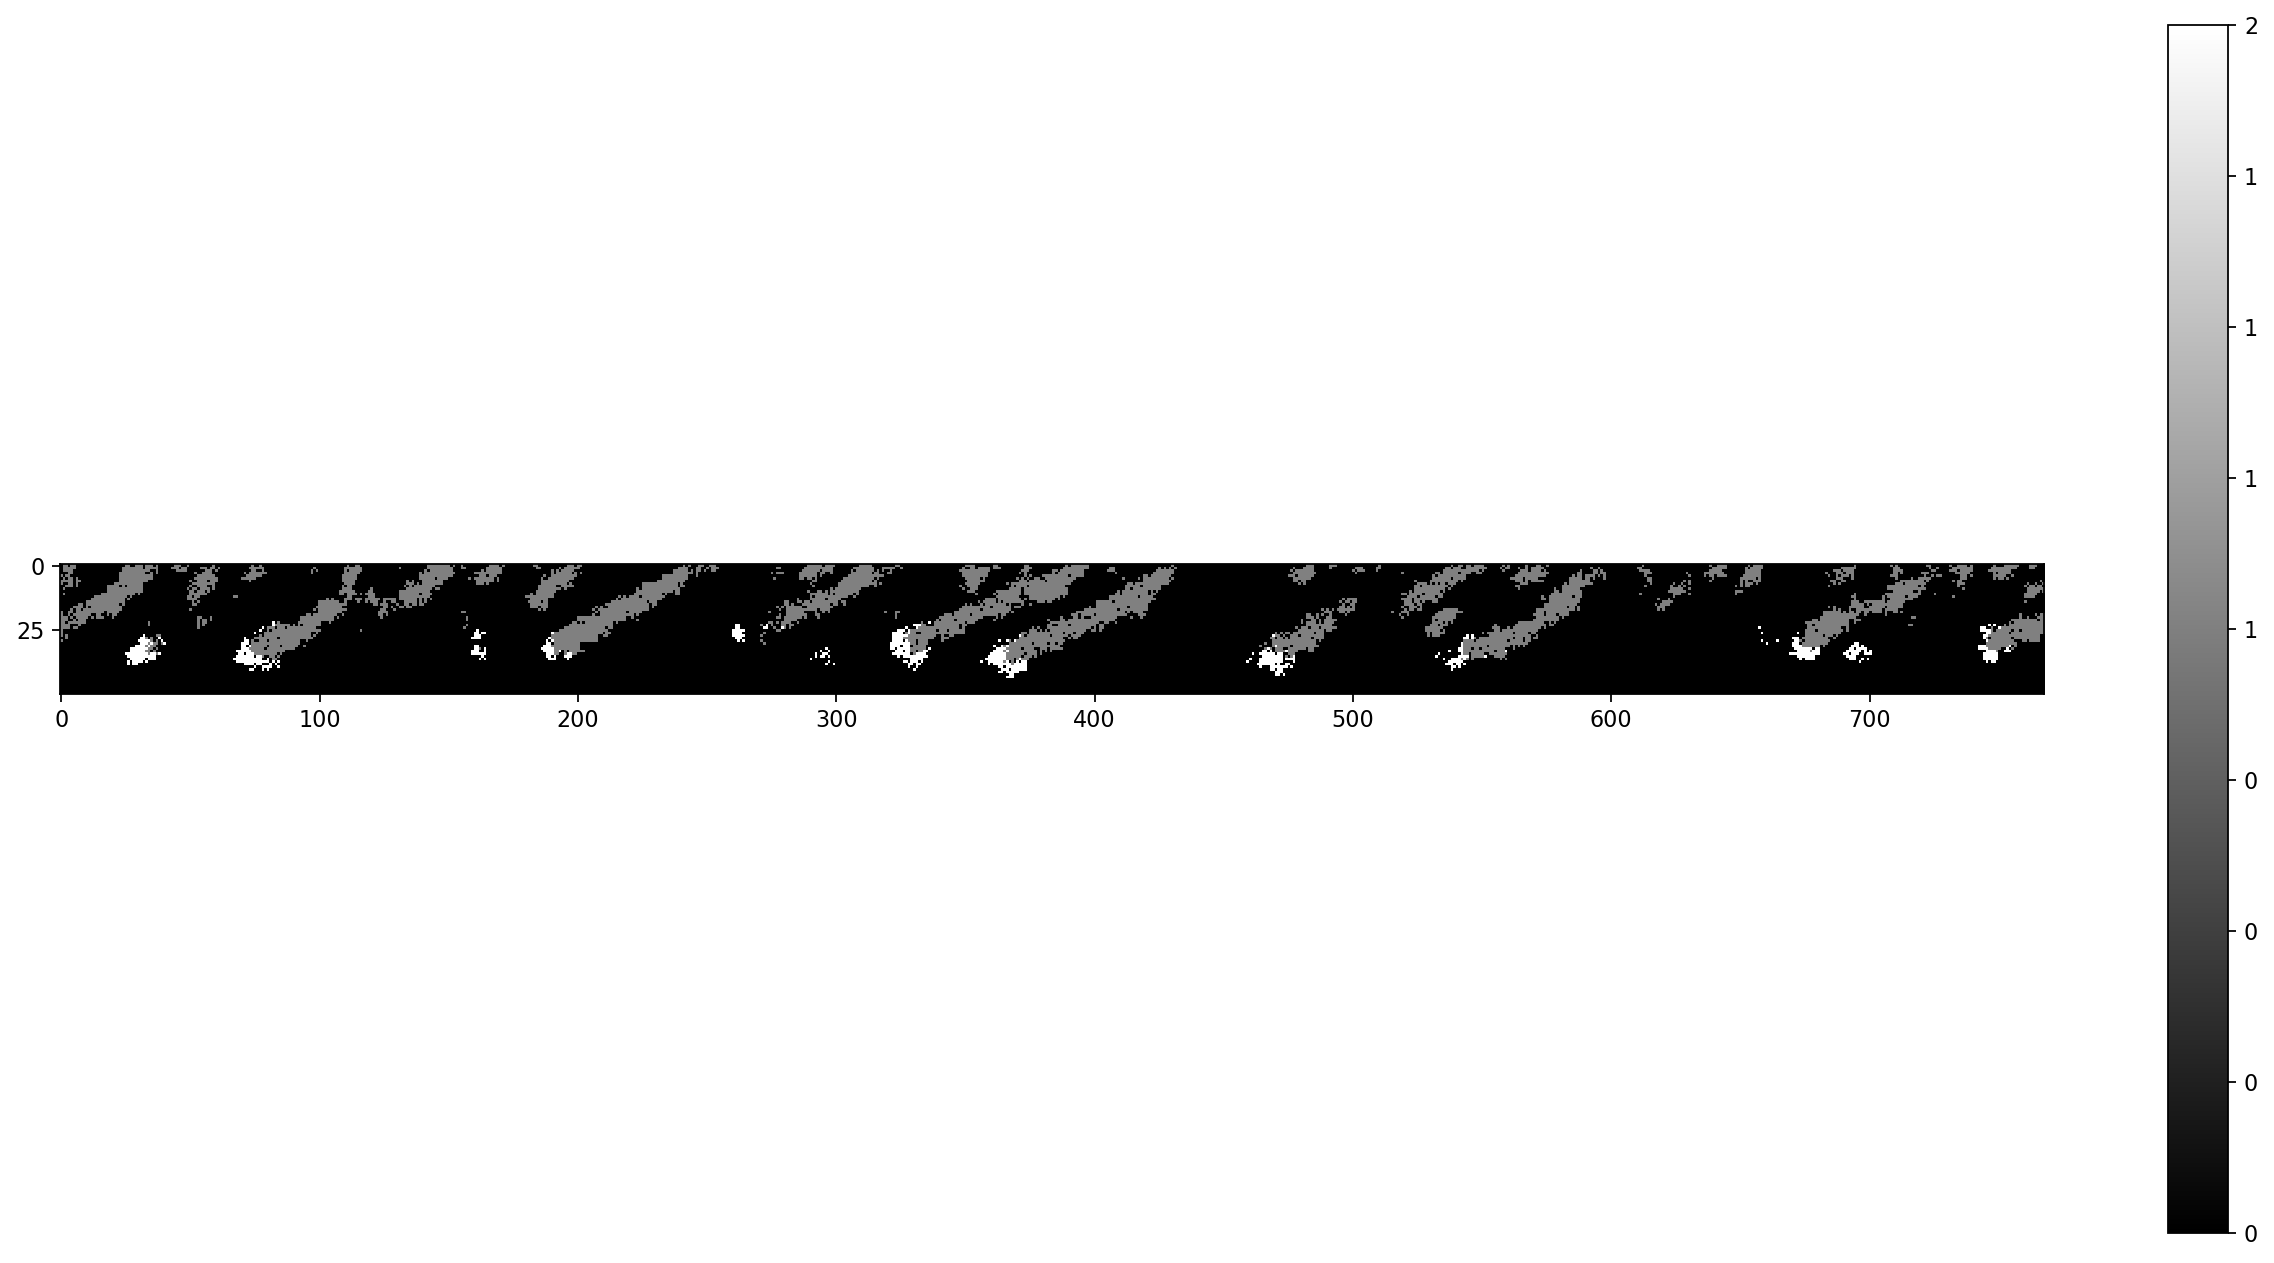

In [33]:
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(0, surfaceAtoms.pointgrid.shape[1])
Y = X
X,Y = np.meshgrid(X,Y)
Z = np.sum(surfaceAtoms.pointgrid[:,:,:,0], axis=0)
#print(Z)
fig = plt.figure()
#ax = fig.add_subplot(projection = "3d")
#surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=False)


plt.subplot(111)
img = plt.imshow(surfaceAtoms.pointgrid[:,0,:,0], cmap="gray")#, vmax=1, vmin=0)
fig.colorbar(img, format='%d')
plt.show()

In [36]:
from ipywidgets import interact

@interact(x=(0,surfaceAtoms.pointgrid.shape[1]-1))
def show_slice(x):
    plt.subplot(111)
    plt.imshow(surfaceAtoms.pointgrid[:,x,:,0], cmap="gray", vmax=np.amax(surfaceAtoms.pointgrid[:,:,:,0]), vmin=0)
    plt.show()

interactive(children=(IntSlider(value=383, description='x', max=767), Output()), _dom_classes=('widget-interac…